# CRTVeto on MC samples


## Imports

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def inTPC_df(row):
    if 0 < row['_nu_vtx_x'] < 256.35:
        if 0 < row['_nu_vtx_z'] < 1036.8:
            if -116.5 < row['_nu_vtx_y'] < 116.5:
                return True
    return False

def inTPC(x_arr, y_arr, z_arr):
    mask = (0 < x_arr)      &  (x_arr < 256.35) & \
           (-116.5 < y_arr) &  (y_arr <116.5)   & \
           (0 < z_arr)      &  (z_arr < 1036.8)
    return mask

## For BNB dirt

In [128]:
MC_dirt = uproot.open('input/G4_dirt_10k.root')['g4veto']['_tree']
MC_dirt.keys()

[b'_intersections',
 b'num_nu',
 b'nu_vtx_x',
 b'nu_vtx_y',
 b'nu_vtx_z',
 b'nu_E',
 b'nu_time',
 b'nu_pdg_code',
 b'nu_ccnc',
 b'_x_cross',
 b'_y_cross',
 b'_z_cross',
 b'_cross_pdg',
 b'_cross_momentum',
 b'_cross_xstart',
 b'_cross_ystart',
 b'_cross_zstart',
 b'_cross_xend',
 b'_cross_yend',
 b'_cross_zend']

In [129]:
# How many events have x CRT crossings?
nr_cross = np.bincount(MC_dirt.array(b'_intersections'))

In [130]:
# Jagged arrays are under the hood 4 flat numpy arrays:
jarr_nu_time = MC_dirt.array(b'nu_time')
jarr_nu_time.content
jarr_nu_time.counts
jarr_nu_time.starts
jarr_nu_time.stops

array([    1,     3,     6, ..., 25829, 25830, 25832])

In [131]:
# Construct the differences between all combinations of neutrinos and crossing MC particles
_cross_xstart = MC_dirt.array(b'_cross_xstart')
nu_vtx_x = MC_dirt.array(b'nu_vtx_x')
pairs_x = nu_vtx_x.cross(_cross_xstart)
diff_x = pairs_x._0 - pairs_x._1

_cross_ystart = MC_dirt.array(b'_cross_ystart')
nu_vtx_y = MC_dirt.array(b'nu_vtx_y')
pairs_y = nu_vtx_y.cross(_cross_ystart)
diff_y = pairs_y._0 - pairs_y._1

_cross_zstart = MC_dirt.array(b'_cross_zstart')
nu_vtx_z = MC_dirt.array(b'nu_vtx_z')
pairs_z = nu_vtx_z.cross(_cross_zstart)
diff_z = pairs_z._0 - pairs_z._1

In [132]:
# Calsulate the distance jagged cross array
dist_xyz = (diff_x**2 + diff_y**2 + diff_z**2)**0.5

In [133]:
nu_cross = []
nu_all = MC_dirt.array(b'nu_E').content

# Try this: I think it is possible to remove all for loops!
for mindist, nu_energy, n_intersections in zip(dist_xyz.argmin(),MC_dirt.array(b'nu_E'), MC_dirt.array(b'_intersections')):
    if n_intersections>0:
        nu_cross.append(nu_energy[int(mindist/n_intersections)])

#print(len(nu_cross))
print('Average number of neutrinos per event: {0:.2f}.'.format(len(nu_all)/len(jarr_nu_time)))
print('Fraction of dirt neutrinos causing a CRT crossing: {0:.2f}%.'.format(len(nu_cross)/len(nu_all)*100))
print('Fraction of dirt events causing a CRT crossing {0:.2f}%.'.format(sum(nr_cross[1:])/sum(nr_cross)*100))

Average number of neutrinos per event: 2.58.
Fraction of dirt neutrinos causing a CRT crossing: 2.71%.
Fraction of dirt events causing a CRT crossing 7.01%.


[  0   1   8  38  78  97 111  85  63  60  27  23  10  16  10]
[  23  690 1973 3391 3803 3448 2925 2352 1731 1263  867  561  363  290
  226]


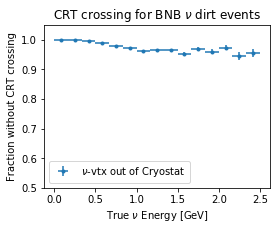

In [173]:
edges = np.linspace(0.,2.5,16)
val1,_ = np.histogram(nu_cross, bins=edges)
val2,_ = np.histogram(nu_all, bins=edges)
eff_in = val1/val2
err_in = np.sqrt(val1*val2/(val1+val2)**3)

print(val1)
print(val2)

fig,ax = plt.subplots(figsize=(4,3.3))

x_axis = edges[:-1]+(edges[1]-edges[0])/2
x_err = (edges[1]-edges[0])/2
#ax.errorbar(x_axis, 1-eff_in, xerr= 0,yerr = err_in, fmt='.', label=r'$\nu$-vtx out of Cryostat',c='b')
ax.errorbar(x_axis, 1-eff_in, xerr= x_err,yerr = err_in, fmt='.', label=r'$\nu$-vtx out of Cryostat',c='C0')
ax.set_ylim(0.5,1.05)
ax.set_xlabel(r'True $\nu$ Energy [GeV]')
ax.set_ylabel(r'Fraction without CRT crossing')
ax.set_title(r'CRT crossing for BNB $\nu$ dirt events')
ax.legend(loc='lower left')
fig.tight_layout()
plt.savefig("./output/crt_crossing_dirt.pdf", bbox_inches="tight")

In [169]:
# Make 2D projections of where these neutrinos are crossing the TPC
x = MC_dirt.array(b'_x_cross').flatten()
y = MC_dirt.array(b'_y_cross').flatten()
z = MC_dirt.array(b'_z_cross').flatten()

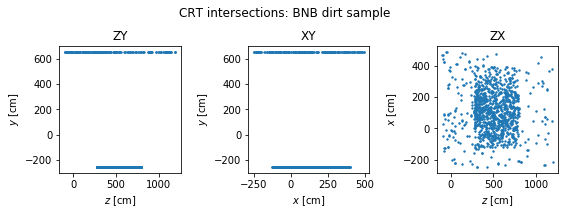

In [170]:
fig, ax = plt.subplots(1,3, figsize=(8,3))

ax[0].scatter(z,y,s=2)
ax[0].set_xlabel(r'$z$ [cm]')
ax[0].set_ylabel(r'$y$ [cm]')
ax[0].set_title(r'ZY')

ax[1].scatter(x,y,s=2)
ax[1].set_xlabel(r'$x$ [cm]')
ax[1].set_ylabel(r'$y$ [cm]')
ax[1].set_title(r'XY')

ax[2].scatter(z,x,s=2)
ax[2].set_xlabel(r'$z$ [cm]')
ax[2].set_ylabel(r'$x$ [cm]')
ax[2].set_title(r'ZX')

fig.suptitle('CRT intersections: BNB dirt sample')
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.savefig("./output/crt_crossing_dirt_proj.pdf", bbox_inches="tight")

## For BNB nue

In [3]:
MC_nue = uproot.open('input/G4_nue_10k.root')['g4veto']['_tree']
MC_nue.keys()

[b'_intersections',
 b'num_nu',
 b'nu_vtx_x',
 b'nu_vtx_y',
 b'nu_vtx_z',
 b'nu_E',
 b'nu_time',
 b'nu_pdg_code',
 b'nu_ccnc',
 b'_x_cross',
 b'_y_cross',
 b'_z_cross',
 b'_cross_pdg',
 b'_cross_momentum',
 b'_cross_xstart',
 b'_cross_ystart',
 b'_cross_zstart',
 b'_cross_xend',
 b'_cross_yend',
 b'_cross_zend']

In [4]:
# This shows that every event has only one neutrino
nr_nue = np.bincount(MC_nue.array(b'num_nu'))
# So we are only interested in the E,x,y,z location of the first neutrino:
nu_e = MC_nue.array(b'nu_E')[:,0]
nu_x = MC_nue.array(b'nu_vtx_x')[:,0]
nu_y = MC_nue.array(b'nu_vtx_y')[:,0]
nu_z = MC_nue.array(b'nu_vtx_z')[:,0]
# This makes it clear that there are only inTPC events in this sample!
nu_intpc = inTPC(nu_x, nu_y, nu_z)

In [5]:
# How many events have x CRT crossings?
nr_cross = np.bincount(MC_nue.array(b'_intersections'))

In [6]:
print('Fraction of nue events in the TPC causing a CRT crossing {0:.2f}%.'.format(nr_cross[1]/len(nu_intpc)*100))

Fraction of nue events in the TPC causing a CRT crossing 0.33%.


## For BNB nu

In [7]:
MC_nu = uproot.open('input/G4_nu_10k.root')['g4veto']['_tree']
print(MC_nu.keys())
MC_nu =  MC_nu.pandas.df(MC_nu.keys())
MC_nu.head()

[b'_intersections', b'_nu_e', b'_nu_ccnc', b'_nu_vtx_x', b'_nu_vtx_y', b'_nu_vtx_z', b'_x_cross', b'_y_cross', b'_z_cross', b'_cross_pdg', b'_cross_momentum', b'_cross_xstart', b'_cross_ystart', b'_cross_zstart', b'_cross_xend', b'_cross_yend', b'_cross_zend']


,_intersections,_nu_e,_nu_ccnc,_nu_vtx_x,_nu_vtx_y,_nu_vtx_z,_x_cross,_y_cross,_z_cross,_cross_pdg,_cross_momentum,_cross_xstart,_cross_ystart,_cross_zstart,_cross_xend,_cross_yend,_cross_zend
0,0,0.473477,0,19.360643,-120.474886,467.401996,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1.236565,1,-24.055375,-65.989518,773.589164,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,4.502198,0,267.635099,67.200220,663.388665,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1.209543,0,292.966373,-30.677627,812.971634,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.896995,0,46.702508,-67.356410,313.147372,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
MC_nu['inTPC'] = MC_nu[['_nu_vtx_x','_nu_vtx_y','_nu_vtx_z']].apply(inTPC_df,axis=1)

In [27]:
val = MC_nu.query('inTPC==1')['_intersections'].value_counts()
print('Percentage crossing upper or lower: {0:.1f}%.'.format(val[1]/sum(val)*100))
upper = MC_nu.query('inTPC==1')[MC_nu.query('inTPC==1')['_y_cross']>120]['_intersections'].value_counts()
print(upper)
print('Percentage crossing upper: {0:.1f}%.'.format(upper/sum(val)*100))

Percentage crossing upper or lower: 3.7%.
1    77
Name: _intersections, dtype: int64


KeyError: 0

In [87]:
MC_nu['inTPC'].value_counts()

False    5488
True     4512
Name: inTPC, dtype: int64

In [108]:
df_inTPC_no = MC_nu.query('inTPC==1')['_nu_e']
df_inTPC_yes = MC_nu.query('_intersections>0 & inTPC==1')['_nu_e']

df_outTPC_no = MC_nu.query('inTPC==0')['_nu_e']
df_outTPC_yes = MC_nu.query('_intersections>0 & inTPC==0')['_nu_e']

print('Fraction of nu events causing a CRT crossing {0:.1f}%.'.format( (1 - (len(df_inTPC_yes+df_outTPC_yes)/len(df_inTPC_no+df_outTPC_no)))*100))

Fraction of nu events causing a CRT crossing 94.7%.


In [99]:
edges = np.linspace(0.,2.5,16)
print(edges)
val1,_ = np.histogram(df_inTPC_no,bins=edges)
val2,_ = np.histogram(df_outTPC_no,bins=edges)
val3,_ = np.histogram(df_inTPC_yes,bins=edges)
val4,_ = np.histogram(df_outTPC_yes,bins=edges)



[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5       ]


In [100]:
eff_in = val3/val1
err_in = np.sqrt(val3*val1/(val1+val3)**3)
eff_out = val4/val2
err_out = np.sqrt(val4*val2/(val2+val4)**3)

In [101]:
print(val3)
print(val1)
print (err_in)
print((val1+val3)**3)

[ 0  0  1  9 16 24 31 31 22 15  7  4  1  2  0]
[  3  92 295 500 641 665 614 496 403 279 181 102  36  26  25]
[0.         0.         0.00337267 0.00584157 0.00601369 0.00698534
 0.0084222  0.01024957 0.01074683 0.01283296 0.01380866 0.0185085
 0.0266593  0.04867037 0.        ]
[       27    778688  25934336 131872229 283593393 327082769 268336125
 146363183  76765625  25412184   6644672   1191016     50653     21952
     15625]


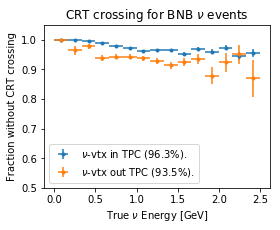

In [158]:
fig,ax = plt.subplots(figsize=(4,3.3))

x_axis = edges[:-1]+(edges[1]-edges[0])/2
x_err = (edges[1]-edges[0])/2
label = r'$\nu$-vtx in TPC ({0:.1f}%).'.format( (1 - len(df_inTPC_yes)/len(df_inTPC_no))*100)
#ax.errorbar(x_axis, 1-eff_in, xerr=0 ,yerr = err_in, fmt='.', label=label, c='r')
ax.errorbar(x_axis, 1-eff_in, xerr=x_err ,yerr = err_in, fmt='.', label=label, c='C0')
label = r'$\nu$-vtx out TPC ({0:.1f}%).'.format( (1 - len(df_outTPC_yes)/len(df_outTPC_no))*100)
#ax.errorbar(x_axis, 1-eff_out, xerr=0 ,yerr = err_out, fmt='.', label=label,c='b')
ax.errorbar(x_axis, 1-eff_out, xerr=x_err ,yerr = err_out, fmt='.', label=label,c='C1')
ax.set_ylim(0.5,1.05)
ax.set_xlabel(r'True $\nu$ Energy [GeV]')
ax.set_ylabel(r'Fraction without CRT crossing')
ax.set_title(r'CRT crossing for BNB $\nu$ events')
ax.legend()
fig.tight_layout()
plt.savefig("./output/crt_crossing_nu.pdf", bbox_inches="tight")

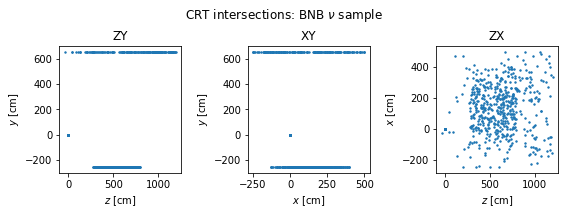

In [168]:
# Make 2D projections of where these neutrinos are crossing the TPC
x = MC_nu['_x_cross']
y = MC_nu['_y_cross']
z = MC_nu['_z_cross']

fig, ax = plt.subplots(1,3, figsize=(8,3))

ax[0].scatter(z,y,s=2)
ax[0].set_xlabel(r'$z$ [cm]')
ax[0].set_ylabel(r'$y$ [cm]')
ax[0].set_title(r'ZY')

ax[1].scatter(x,y,s=2)
ax[1].set_xlabel(r'$x$ [cm]')
ax[1].set_ylabel(r'$y$ [cm]')
ax[1].set_title(r'XY')

ax[2].scatter(z,x,s=2)
ax[2].set_xlabel(r'$z$ [cm]')
ax[2].set_ylabel(r'$x$ [cm]')
ax[2].set_title(r'ZX')

fig.suptitle(r'CRT intersections: BNB $\nu$ sample')
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.savefig("./output/crt_crossing_nu_proj.pdf", bbox_inches="tight")